Quy trinh

In [11]:
# !pip install statsmodels
!pip install hurst


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Bước 1: Mô tả dữ liệu

Dữ liệu chứa thông tin lợi suất trái phiếu chính phủ 3 tháng từ năm 1960 đến 2024. Dữ liệu bao gồm các cột:

- Date: Ngày quan sát.
- Open, High, Low, Close: Giá trị lợi suất mở cửa, cao nhất, thấp nhất và đóng cửa trong ngày.
- Adj Close: Giá trị đóng cửa đã được điều chỉnh, đại diện tốt nhất cho chuỗi thời gian phân tích.
- Volume: Khối lượng giao dịch, nhưng với lợi suất trái phiếu thì thường là 0 hoặc không quan trọng.

Chuỗi thời gian này:

- Có thể chứa xu hướng (trend), ví dụ: sự thay đổi của lợi suất qua các thời kỳ kinh tế.
- Có thể không dừng (non-stationary) do sự biến động trong dài hạn hoặc các cú sốc kinh tế.
- Có thể chứa thành phần mùa vụ (seasonality) hoặc tự tương quan (autocorrelation).

**Mục tiêu**: Phân tích và dự báo chuỗi thời gian Adj Close.

# Bước 2: Quy trình phân tích
## 2.1. Khám phá dữ liệu (EDA)

**Mục tiêu**:

- Nhận diện xu hướng (nếu có).
- Kiểm tra chu kỳ, mùa vụ, hoặc tự tương quan.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Đọc dữ liệu
data = pd.read_csv("data/3MonthTreasury.csv", parse_dates=["Date"], index_col="Date")
data = data.sort_index()

# Chọn cột Adj Close để phân tích
adj_close = data["Adj Close"]

In [3]:
adj_close.head()

Date
1960-01-04    4.52
1960-01-05    4.55
1960-01-06    4.68
1960-01-07    4.63
1960-01-08    4.59
Name: Adj Close, dtype: float64

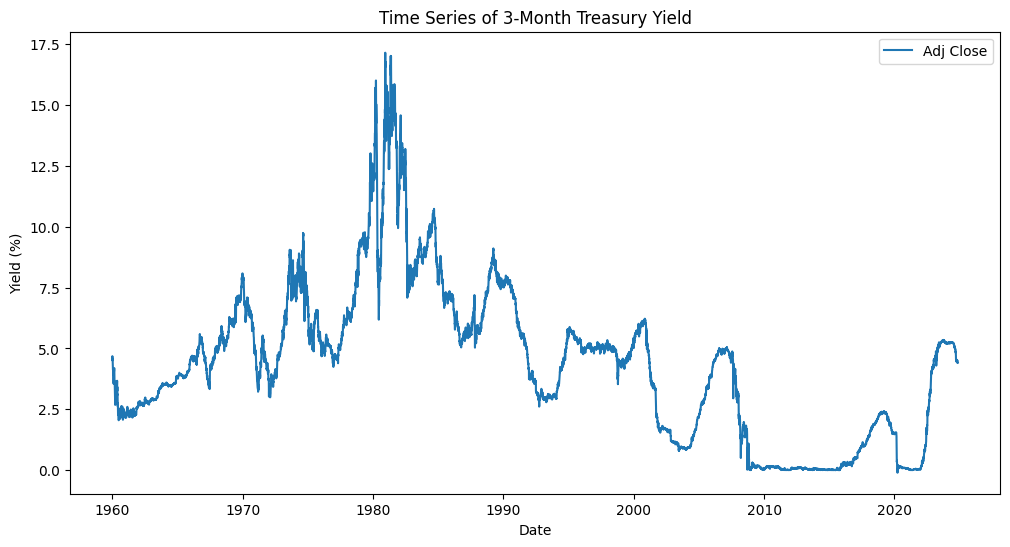

In [4]:
# Vẽ biểu đồ chuỗi thời gian
plt.figure(figsize=(12, 6))
plt.plot(adj_close, label="Adj Close")
plt.title("Time Series of 3-Month Treasury Yield")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.savefig("figs/eda_1.png")
plt.show()

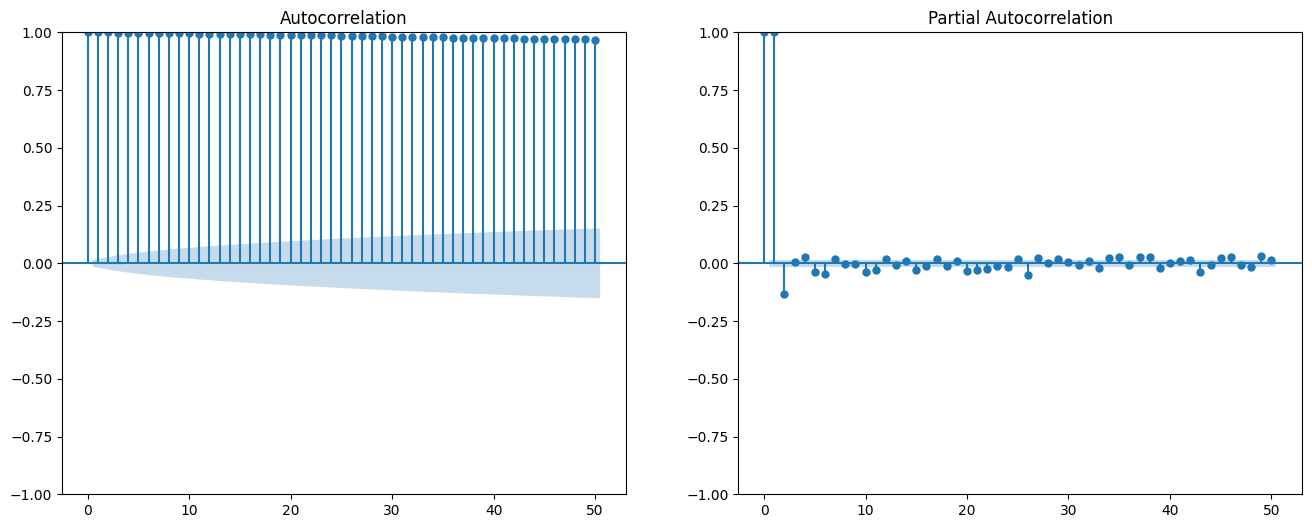

In [5]:
# ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(adj_close, lags=50, ax=axes[0])
plot_pacf(adj_close, lags=50, ax=axes[1])
plt.savefig("figs/eda_2.png")
plt.show()

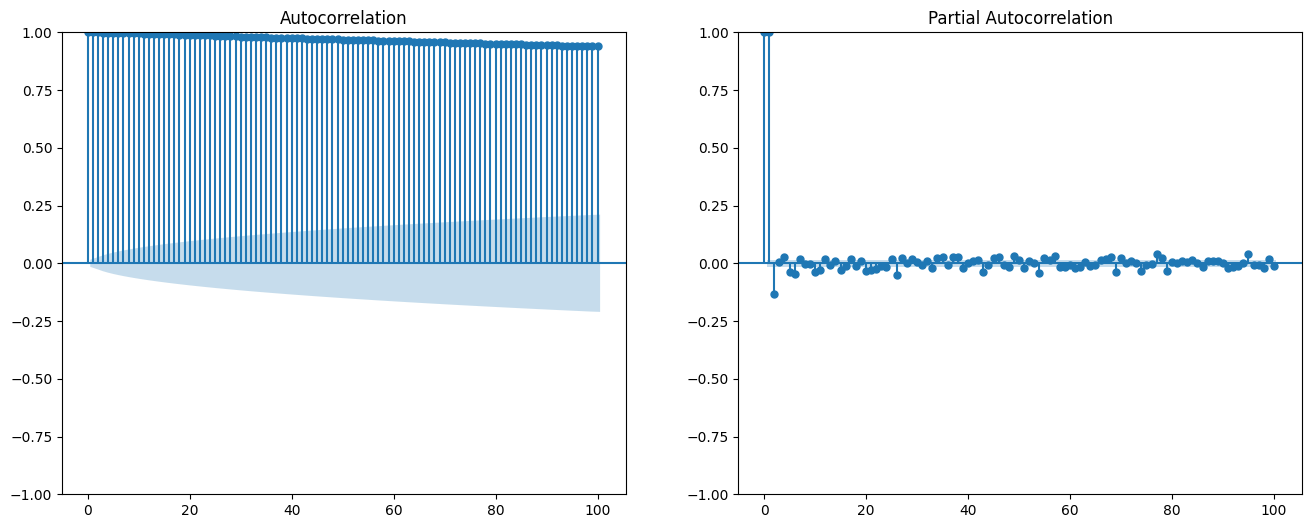

In [6]:
# ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(adj_close, lags=100, ax=axes[0])
plot_pacf(adj_close, lags=100, ax=axes[1])
plt.savefig("figs/eda_3.png")
plt.show()

In [3]:
# Thống kê cơ bản
summary_stats = adj_close.describe()
print("Summary Statistics:\n", summary_stats)

# Skewness và Kurtosis
from scipy.stats import skew, kurtosis

skewness = skew(adj_close.dropna())
kurt = kurtosis(adj_close.dropna())
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")
# Skewness giúp kiểm tra tính đối xứng của chuỗi thời gian.
# Kurtosis cho biết mức độ tập trung của dữ liệu, hữu ích trong việc kiểm tra sự hiện diện của các giá trị ngoại lai.

Summary Statistics:
 count    16229.000000
mean         4.361725
std          3.153857
min         -0.105000
25%          1.900000
50%          4.540000
75%          5.910000
max         17.139999
Name: Adj Close, dtype: float64
Skewness: 0.7501
Kurtosis: 0.9445


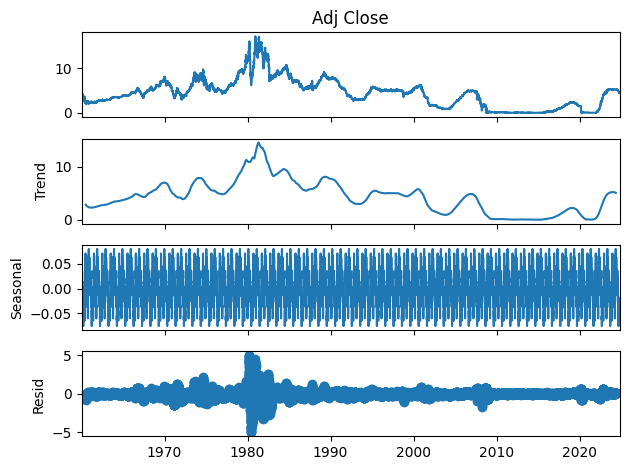

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Phân rã chuỗi thời gian (additive)
decomposition = seasonal_decompose(adj_close, model="additive", period=252)  # 252 ngày = 1 năm giao dịch
decomposition.plot()
plt.show()
# Phân tích xu hướng, mùa vụ và chu kỳ
# Decomposition (phân rã chuỗi thời gian)

# Phân tách chuỗi thời gian thành các thành phần:

#     Trend (xu hướng): Mô tả thay đổi dài hạn.
#     Seasonality (mùa vụ): Mô tả mẫu lặp lại theo chu kỳ.
#     Residuals (phần dư): Phần còn lại không giải thích được.

# Nếu phần dư (residual) không chứa xu hướng hoặc mùa vụ, chuỗi phù hợp để mô hình hóa.
# Sự tồn tại của các thành phần này giúp xác định liệu ARIMA, ETS, hay các mô hình phi tuyến như LSTM sẽ phù hợp hơn.

### Phân tích sự phân phối

Kiểm tra phân phối của dữ liệu để xác định tính chuẩn (normality) hoặc sự bất thường.

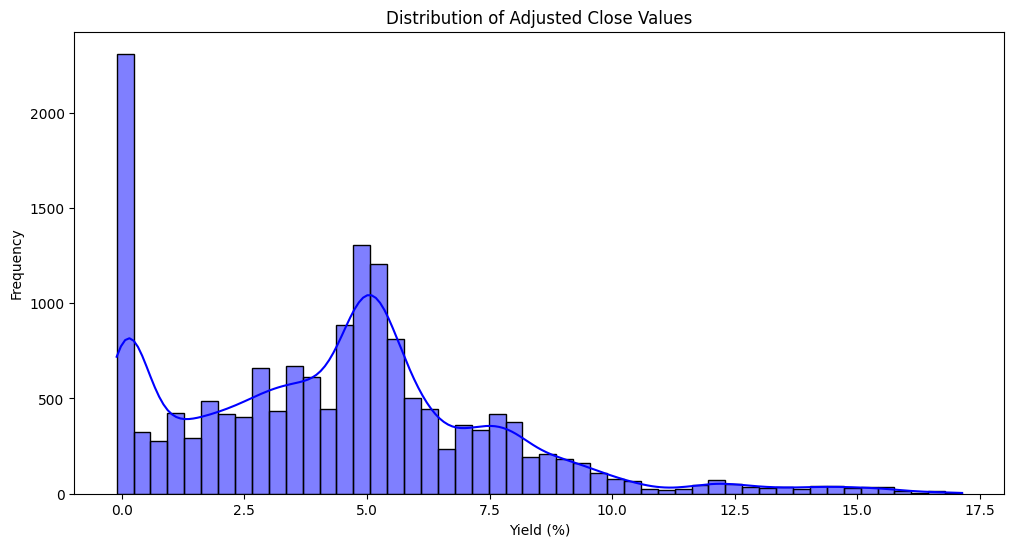

In [5]:
import seaborn as sns

# Histogram và KDE
plt.figure(figsize=(12, 6))
sns.histplot(adj_close, kde=True, bins=50, color="blue")
plt.title("Distribution of Adjusted Close Values")
plt.xlabel("Yield (%)")
plt.ylabel("Frequency")
plt.show()


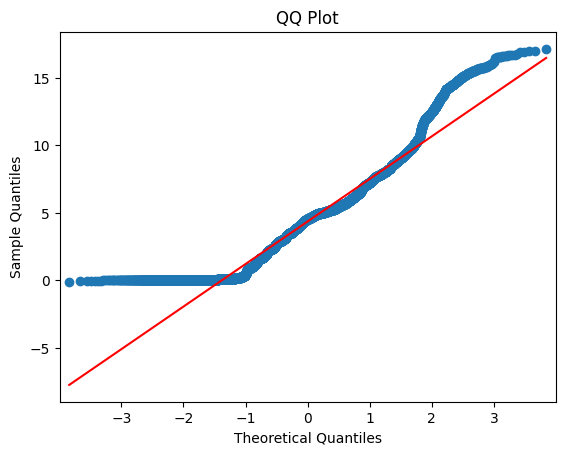

In [6]:
# QQ-Plot
sm.qqplot(adj_close.dropna(), line="s")
plt.title("QQ Plot")
plt.show()
# Nếu dữ liệu không chuẩn, có thể cần các phép biến đổi như log hoặc Box-Cox để giảm thiểu sự bất ổn định.

In [7]:
# Tính toán chỉ số tự tương quan
# Sử dụng ACF (Autocorrelation Function) và PACF (Partial Autocorrelation Function) để kiểm tra sự tự tương quan chi tiết hơn.

from statsmodels.stats.diagnostic import acorr_ljungbox

# Tính toán ACF và PACF
acf_values = sm.tsa.acf(adj_close.dropna(), nlags=50)
pacf_values = sm.tsa.pacf(adj_close.dropna(), nlags=50)

# Ljung-Box Test
lb_test = acorr_ljungbox(adj_close.dropna(), lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test Results:\n", lb_test)

# ACF và PACF xác định độ trễ (lag) nào có ảnh hưởng mạnh nhất.
# Ljung-Box test kiểm tra liệu chuỗi thời gian có nhiễu trắng hay không (white noise).


Ljung-Box Test Results:
           lb_stat  lb_pvalue
10  161502.432533        0.0
20  321259.240170        0.0
30  478969.622544        0.0


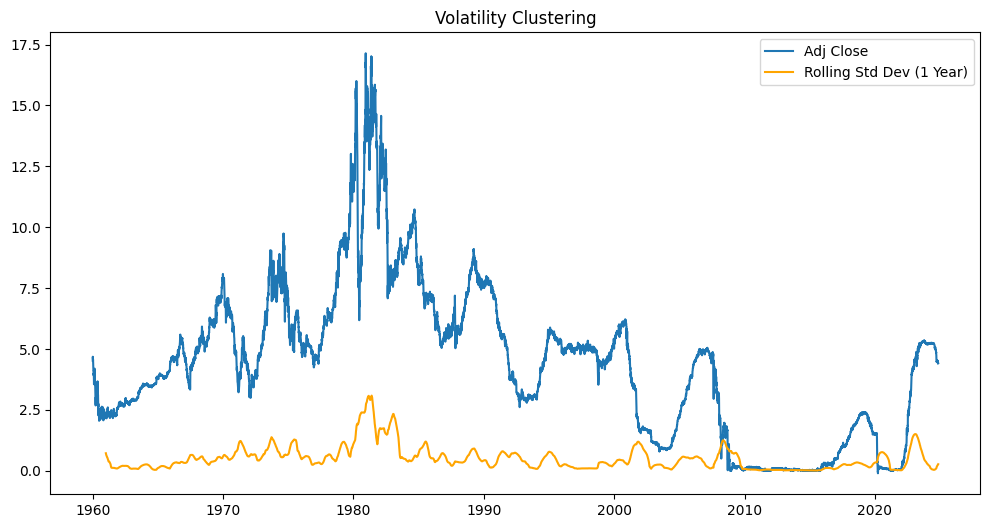

In [8]:
# Phân tích tính bất ổn định

# Dữ liệu tài chính thường có biến động thay đổi (volatility clustering). Kiểm tra hiện tượng này là quan trọng trước khi chọn mô hình.

# Tính toán rolling standard deviation
rolling_std = adj_close.rolling(window=252).std()

# Biểu đồ rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(adj_close, label="Adj Close")
plt.plot(rolling_std, label="Rolling Std Dev (1 Year)", color="orange")
plt.title("Volatility Clustering")
plt.legend()
plt.show()

# Nếu dữ liệu có tính bất ổn định, hãy thử mô hình ARCH hoặc GARCH.

In [9]:
# Kiểm tra đơn vị gốc (Stationarity Test)

#     Ngoài ADF test, bạn có thể sử dụng KPSS Test hoặc PP Test để đánh giá tính dừng của chuỗi.

from statsmodels.tsa.stattools import kpss

# Kiểm định KPSS
kpss_test = kpss(adj_close.dropna(), regression="c")
print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])

# Nếu ADF và KPSS mâu thuẫn, có thể cần phân tích thêm hoặc sử dụng phương pháp lai (hybrid).

KPSS Statistic: 8.27666266936689
p-value: 0.01


/tmp/ipykernel_1073432/1104701067.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(adj_close.dropna(), regression="c")


Phân tích biến động dài hạn và tương quan chéo
Hurst Exponent

Hurst Exponent đo lường mức độ chuỗi thời gian có xu hướng hoặc mean-reverting.

In [12]:
from hurst import compute_Hc

H, c, data = compute_Hc(adj_close.dropna())
print("Hurst Exponent:", H)

# H<0.5: Mean-reverting (phù hợp với ARIMA).
# H=0.5: Random walk.
# H>0.5: Xu hướng (trend-following).

Hurst Exponent: 0.5346855546388221


Cải tiến lựa chọn mô hình dựa trên EDA

    ARIMA: Phù hợp nếu chuỗi không có mùa vụ và trở thành dừng sau phép sai phân.
    ETS: Nếu phân rã chuỗi cho thấy xu hướng và mùa vụ rõ ràng.
    ARCH/GARCH: Nếu chuỗi có tính bất ổn định cao (volatility clustering).
    LSTM: Nếu chuỗi có tính phi tuyến hoặc các mối quan hệ phức tạp mà mô hình truyền thống không giải thích được.

## 2.2. Kiểm tra tính dừng

Dùng kiểm định Augmented Dickey-Fuller (ADF) để kiểm tra xem chuỗi có dừng hay không.

In [7]:
from statsmodels.tsa.stattools import adfuller

# Kiểm định ADF
adf_test = adfuller(adj_close.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

if adf_test[1] < 0.05:
    print("Chuỗi thời gian dừng (reject null hypothesis).")
else:
    print("Chuỗi thời gian không dừng (fail to reject null hypothesis).")

ADF Statistic: -2.340499287985867
p-value: 0.15923852249623738
Chuỗi thời gian không dừng (fail to reject null hypothesis).


Xử lý nếu không dừng:

Sử dụng phép sai phân (differencing).

In [8]:
# Sai phân lần 1
diff_adj_close = adj_close.diff().dropna()

# Kiểm tra lại tính dừng
adf_test_diff = adfuller(diff_adj_close)
print("ADF Statistic (Differenced):", adf_test_diff[0])
print("p-value (Differenced):", adf_test_diff[1])

ADF Statistic (Differenced): -19.013830215965182
p-value (Differenced): 0.0


## 2.3. Chia tập dữ liệu

Chia dữ liệu thành hai phần:

- Tập huấn luyện (train): 80% đầu tiên của dữ liệu.
- Tập kiểm thử (test): 20% cuối cùng.

In [ ]:
train_size = int(len(adj_close) * 0.8)
train, test = adj_close[:train_size], adj_close[train_size:]

## 2.4. Thử nghiệm các mô hình

In [ ]:
# Naïve Methods
# Dự báo giá trị cuối cùng của tập huấn luyện cho toàn bộ tập kiểm thử
naive_forecast = train.iloc[-1]
naive_predictions = [naive_forecast] * len(test)

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error
import numpy as np

naive_rmse = np.sqrt(mean_squared_error(test, naive_predictions))
print("Naïve RMSE:", naive_rmse)

In [ ]:
# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

# Xác định tham số ARIMA
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Dự báo
arima_predictions = model_fit.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))
print("ARIMA RMSE:", arima_rmse)

In [ ]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Mô hình Holt-Winters
hw_model = ExponentialSmoothing(train, seasonal=None, trend="add").fit()
hw_predictions = hw_model.forecast(steps=len(test))

hw_rmse = np.sqrt(mean_squared_error(test, hw_predictions))
print("Holt-Winters RMSE:", hw_rmse)


In [ ]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Tiền xử lý dữ liệu cho LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Xây dựng tập dữ liệu dạng LSTM
def create_lstm_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10
X_train, y_train = create_lstm_dataset(train_scaled, look_back)
X_test, y_test = create_lstm_dataset(test_scaled, look_back)

# Reshape để phù hợp với LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Dự báo với LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

lstm_rmse = np.sqrt(mean_squared_error(test[look_back:], lstm_predictions))
print("LSTM RMSE:", lstm_rmse)


# Bước 3: So sánh và chọn mô hình

So sánh giá trị RMSE của từng mô hình. Chọn mô hình tốt nhất cho dự báo dài hạn.

# Bước 4: Dự báo

Sử dụng mô hình được chọn để dự báo giá trị tương lai.